# Parte 1: Titanic - Machine Learning from Disaster

### Este es el link para descargar [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic) 


In [ ]:
#! conda install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.stats import skew, sem, t
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score
import xgboost as xgb
import warnings
import pickle

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Load data

In [3]:
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.drop(['PassengerId','Ticket'], axis=1, inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


# Exploratory Data Analysis (EDA) & Feature Engineering

## 1. Missing data

In [7]:
col_missing=[name for name in train.columns if np.sum(train[name].isnull()) !=0]
col_missing

['Age', 'Cabin', 'Embarked']

In [8]:
train[col_missing].isnull().sum()*100/len(train)

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

<Axes: >

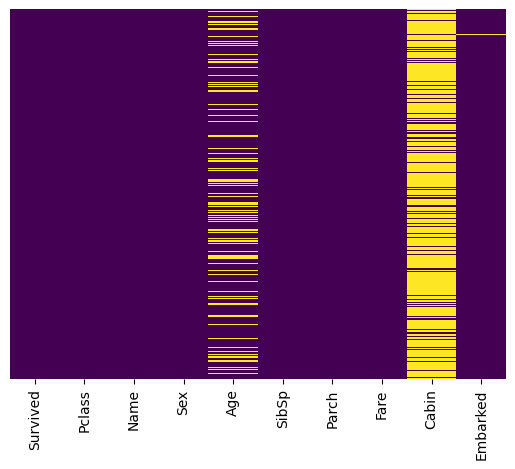

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
# Impute missing values of 'Embarked' by mode
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']


<Figure size 640x480 with 0 Axes>

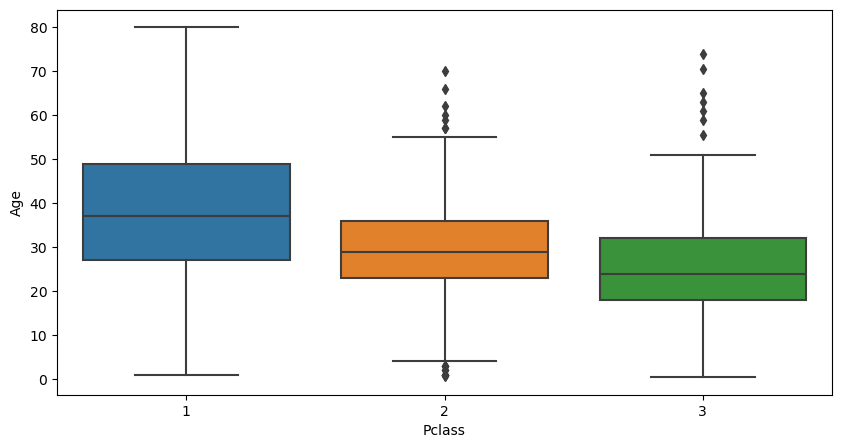

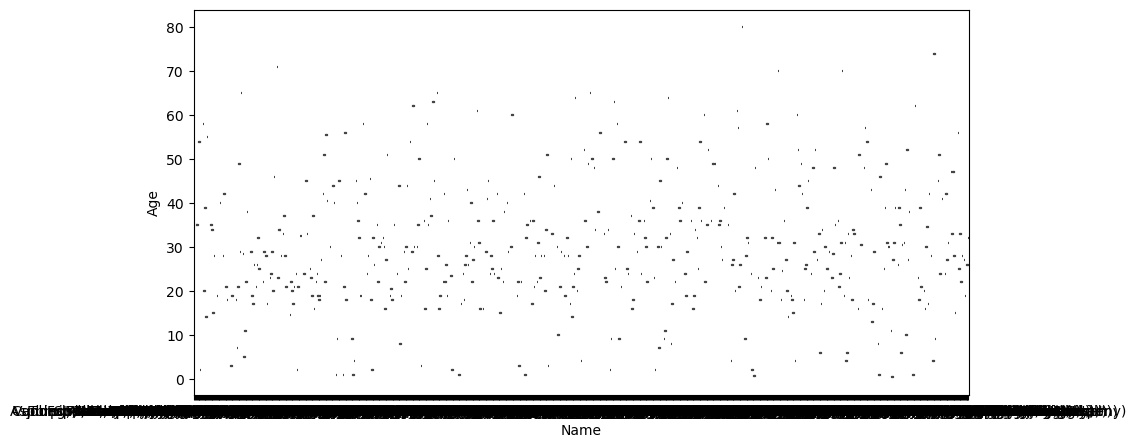

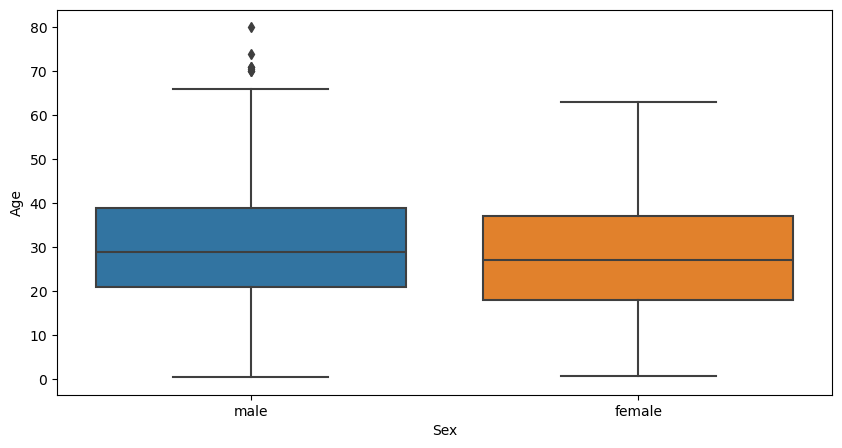

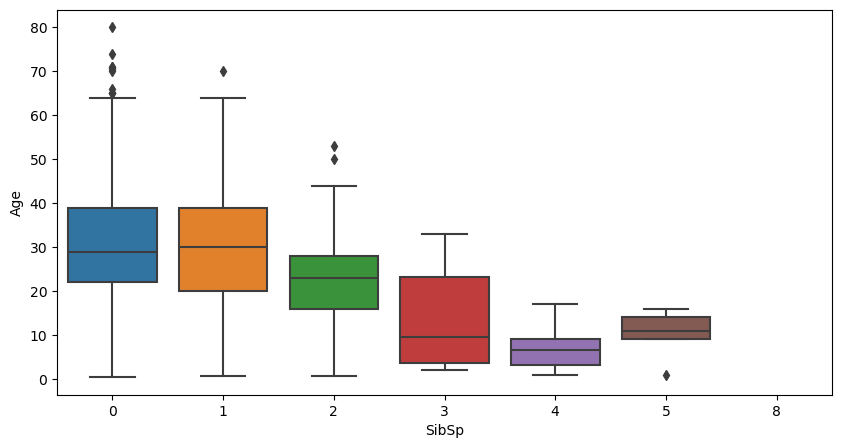

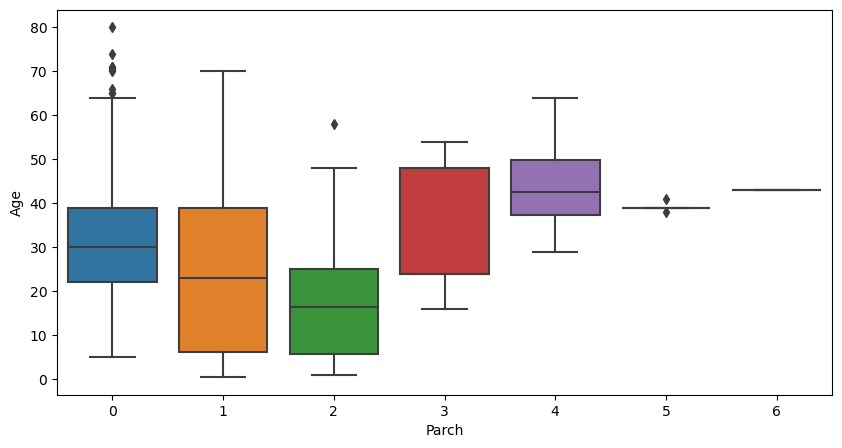

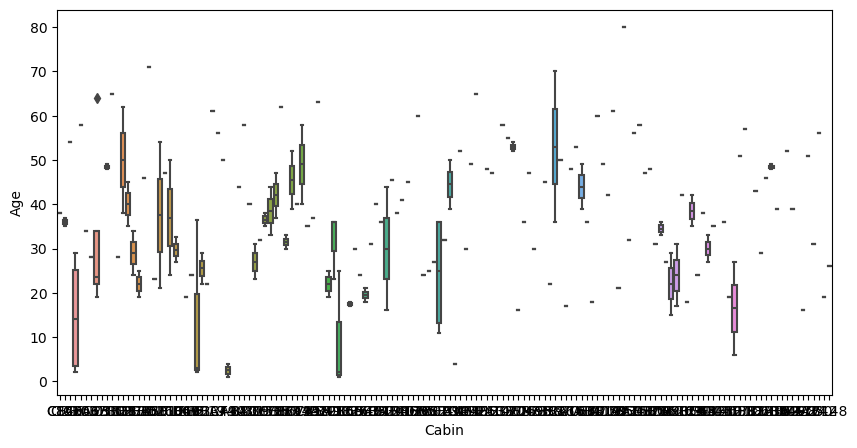

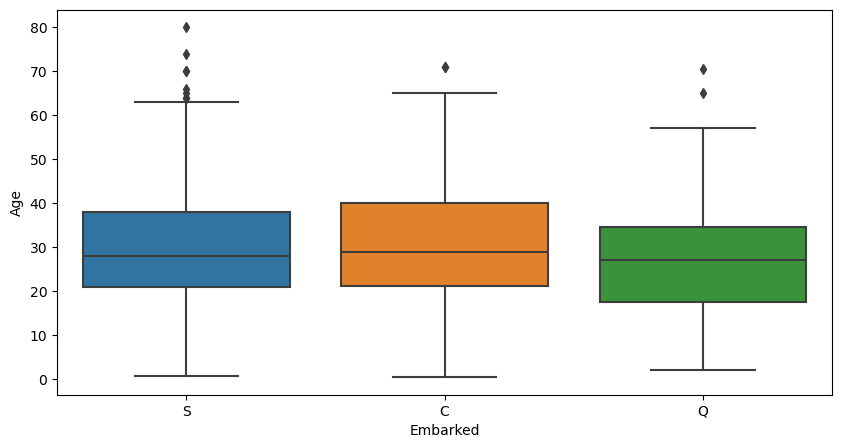

In [11]:
# Plotting Age against any other variable to uncover any potential association
cols = [column for column in train.columns if train[column].dtype in ['int64','object']]
print(cols)
for i, column in enumerate(cols):
    if column == 'Survived':
        pass
    else:
        var = column
        plt.figure(i)
        f, ax = plt.subplots(figsize=(10, 5))
        sns.boxplot(x=var,y='Age',data=train)

In [12]:
median_age_Pclass1 = train[train['Pclass']==1]['Age'].median()
median_age_Pclass2 = train[train['Pclass']==2]['Age'].median()
median_age_Pclass3 = train[train['Pclass']==3]['Age'].median()

def impute_age(data):
    Age = data['Age']
    Pclass = data['Pclass']
    
    if pd.isnull(Age):
        if Pclass == 1:
            return median_age_Pclass1
        elif Pclass == 2:
            return median_age_Pclass2
        else:
            return median_age_Pclass3
    else:
        return Age

In [13]:
# Impute missing values by age median per passenger class:
train['Age'] = train.apply(impute_age,axis=1)

In [14]:
# "Cabin" Almost 80% of the values are missing
# I am imputing missing values with 'U' (Unknown)
train['Cabin'] = train['Cabin'].fillna('U')

In [15]:
# After imputing the missing values in these three columns any additional missing value that shows during inference will be droped
train.dropna(inplace=True)

In [16]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

## 2. Plotting variables against "Survival"

In [17]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [18]:
categorical = [ 'Pclass','Sex','Embarked','Cabin_data']
continuous_and_ordinal = ['Age', 'Fare', 'SibSp', 'Parch']

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

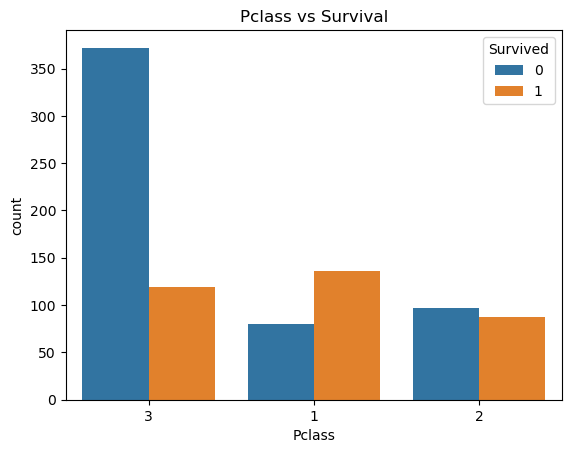

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

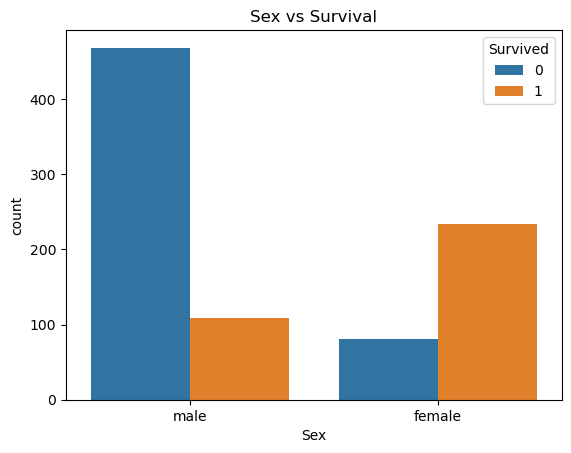

<Figure size 640x480 with 0 Axes>

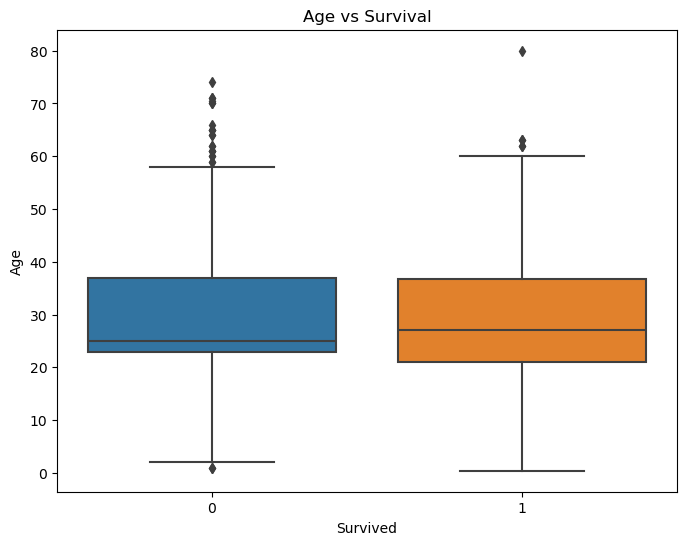

<Figure size 640x480 with 0 Axes>

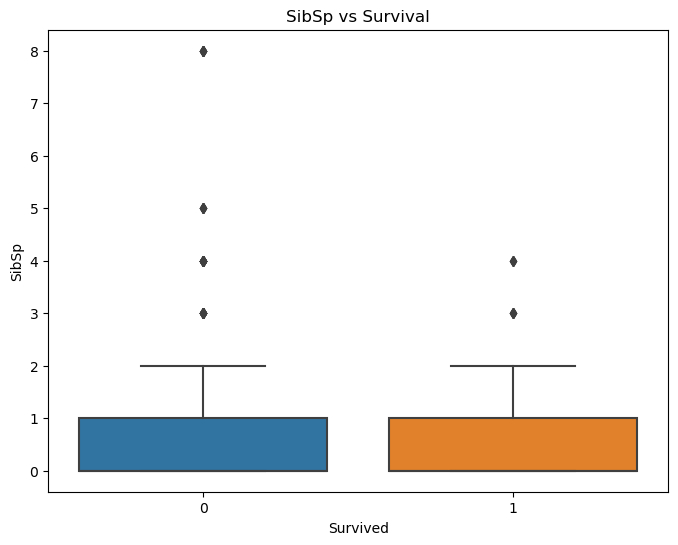

<Figure size 640x480 with 0 Axes>

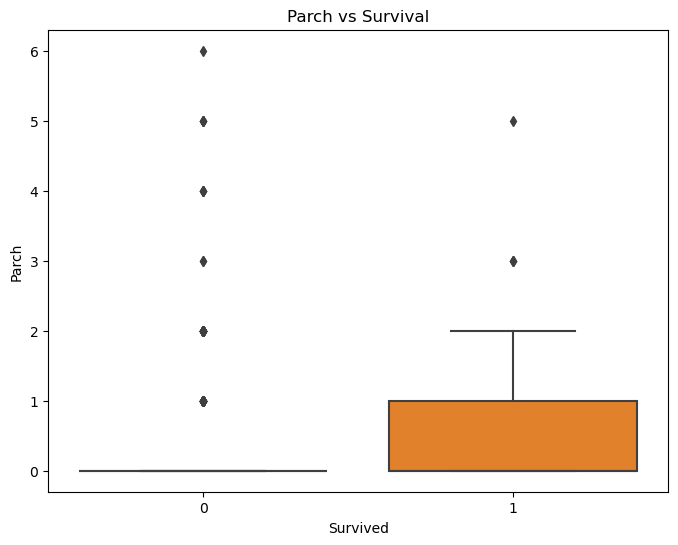

<Figure size 640x480 with 0 Axes>

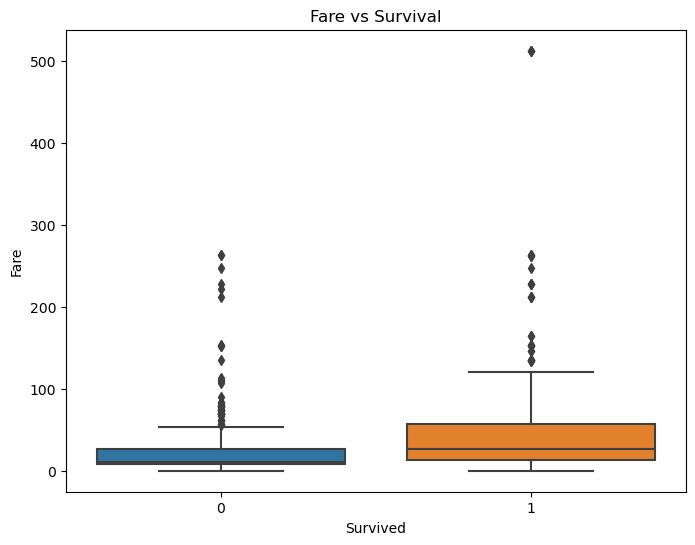

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

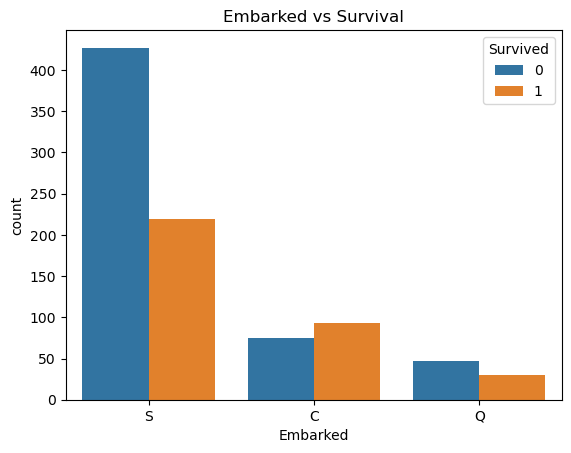

In [19]:
for i, column in enumerate(train.columns):
    plt.figure(i)
    plt.figure(figsize=(8, 6))
    
    if column == 'Survived':
        pass
    elif column in categorical:    
        df = train.copy()
        df['Survived'] = df['Survived'].astype(str)
        df[column] = df[column].astype(str)
        plt.figure(i)
        f, ax = plt.subplots()
        sns.countplot(x=column, hue="Survived", data=df)
        plt.title(f'{column} vs Survival')
        plt.show()
    elif column in continuous_and_ordinal:  
        sns.boxplot(x='Survived', y=column, data=train)
        plt.title(f'{column} vs Survival')
        plt.show()      

## 3. Feature Engineering

In [20]:
# Title extraction from name: 
# Extracting titles (like Mr., Mrs., Miss, etc.) from the "Name" column to group passengers by social status or gender.
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
train.drop('Name', axis=1, inplace=True)
train['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [21]:
# Family Size: 
# Combining SibSp (siblings/spouses) and Parch (parents/children) into a single feature called FamilySize which includes the person themselves.
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['FamilySize'].value_counts()

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

In [22]:
# IsAlone Feature
# Creating a binary feature that indicates whether a passenger is traveling alone or with family.
train['IsAlone'] = 1  # Initialize to 1, assuming passenger is alone
train['IsAlone'].loc[train['FamilySize'] > 1] = 0  # If family size > 1, set to 0
train['IsAlone'] = train['IsAlone'].astype(str)

/var/folders/_p/l8jxhtkd7q30jh43lzk4rhzr0000gp/T/ipykernel_41470/2498016145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IsAlone'].loc[train['FamilySize'] > 1] = 0  # If family size > 1, set to 0


In [23]:
# Age Bining
train['AgeBin'] = pd.cut(train['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teenager', 'Adult', 'Middle_Aged', 'Senior']).astype(str)

In [24]:
# Extract the first letter (Deck level) from the Cabin Column. Previously if the data was missing we assigned "U"
train['Deck'] = train['Cabin'].apply(lambda x: x[0])
train['Deck'].value_counts()

Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [25]:
train.drop('Cabin', axis=1, inplace=True)

In [26]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
FamilySize    0
IsAlone       0
AgeBin        0
Deck          0
dtype: int64

## 3. Processing categorical variables

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   Title       891 non-null    object 
 9   FamilySize  891 non-null    int64  
 10  IsAlone     891 non-null    object 
 11  AgeBin      891 non-null    object 
 12  Deck        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [28]:
categorical = [column for column in train.columns if train[column].dtype=='object']
categorical

# 'Pclass' is the passenger calss ('int64'), it is categorical as well but it should be treated as an ordinal encoded variable

['Sex', 'Embarked', 'Title', 'IsAlone', 'AgeBin', 'Deck']

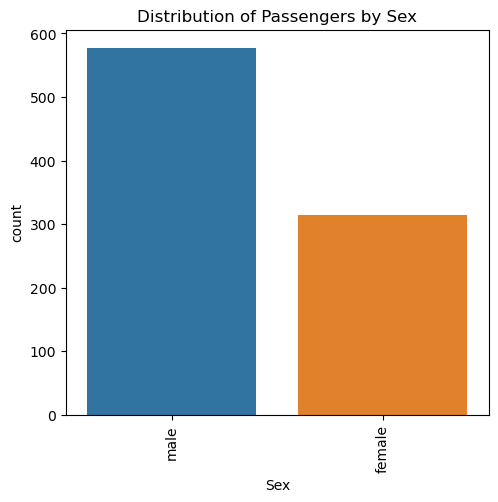

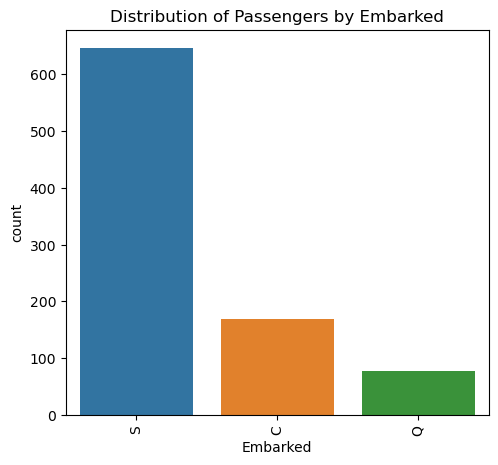

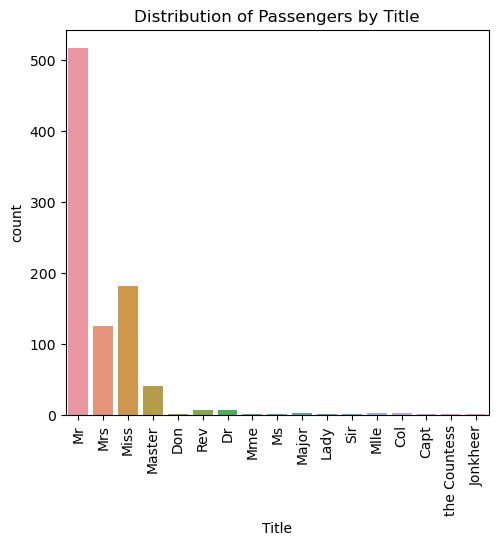

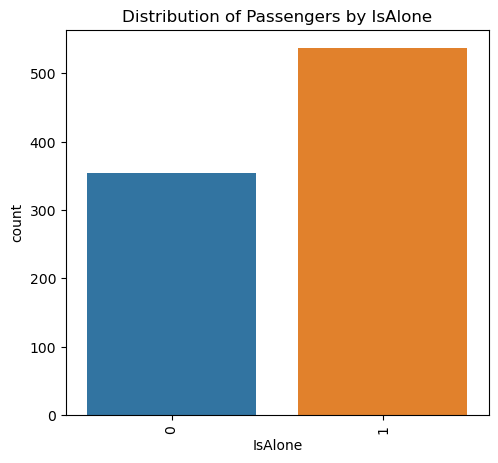

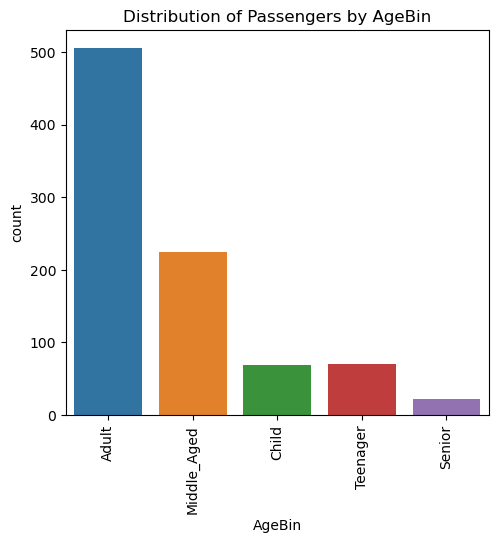

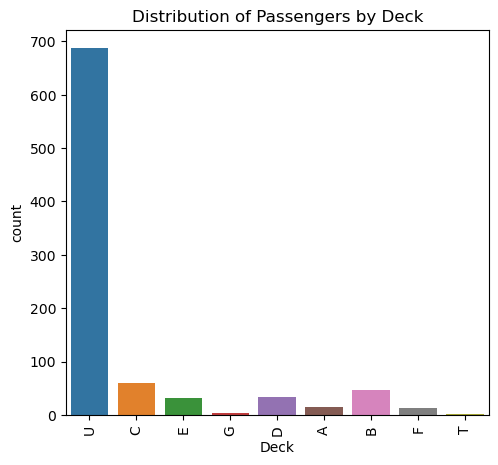

In [29]:
for i, column in enumerate(categorical):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plot = sns.countplot(x=column, data=train)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.title('Distribution of Passengers by ' + column)

    plt.show()

### 3.1. One hot encoding: "Sex" and "Embarked" because they don't have a natural order

In [30]:
categorical

['Sex', 'Embarked', 'Title', 'IsAlone', 'AgeBin', 'Deck']

In [31]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked','IsAlone'], drop_first=True)

### 3.2 Ordinal encoding for "AgeBin", "Title" and "Deck"

In [32]:
# Ordinal encoding 'AgeBin'
agebin_order = ["Child", "Teenager", "Adult", "Middle_Aged","Senior"]

# Convert 'AgeBin' to categorical types with ordered=True
train['AgeBin'] = pd.Categorical(train['AgeBin'], categories=agebin_order, ordered=True)

# Apply ordinal encoding by converting categories to integers
train['AgeBin_encoded'] = train['AgeBin'].cat.codes

# Display the result
print(train[['AgeBin', 'AgeBin_encoded']].value_counts())

AgeBin       AgeBin_encoded
Adult        2                 505
Middle_Aged  3                 225
Teenager     1                  70
Child        0                  69
Senior       4                  22
Name: count, dtype: int64


In [33]:
train.drop('AgeBin', axis=1, inplace=True)

In [34]:
# Ordinal encoding for "Title"

# Define dictionary of titles we want to consider
title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Dr":5, "Rev":6}

# If a category does not appear in this disctionary we will assign the value to zero.
train['Title_encoded'] = train['Title'].map(lambda x:title_mapping.get(x, 0))

# Display the result
print(train[['Title', 'Title_encoded']].value_counts())

Title         Title_encoded
Mr            3                517
Miss          2                182
Mrs           4                125
Master        1                 40
Dr            5                  7
Rev           6                  6
Major         0                  2
Col           0                  2
Mlle          0                  2
Sir           0                  1
Ms            0                  1
Capt          0                  1
Mme           0                  1
Lady          0                  1
Jonkheer      0                  1
Don           0                  1
the Countess  0                  1
Name: count, dtype: int64


In [35]:
train.drop('Title', axis=1, inplace=True)

In [36]:
train['Deck'].value_counts()

Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [37]:
# Ordinal encoding for Deck

# Define dictionary of titles we want to consider
deck_mapping = deck_mapping = {
    'A': 1,  # Upper decks
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,  # Lower decks
    'T': 8,  
    'U': 0   # Unknown deck
}

# If a category does not appear in this disctionary we will assign the value to zero.
train['Deck_encoded'] = train['Deck'].map(lambda x:deck_mapping.get(x, 0))

# Display the result
print(train[['Deck', 'Deck_encoded']].value_counts())

Deck  Deck_encoded
U     0               687
C     3                59
B     2                47
D     4                33
E     5                32
A     1                15
F     6                13
G     7                 4
T     8                 1
Name: count, dtype: int64


In [38]:
train.drop('Deck', axis=1, inplace=True)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   FamilySize      891 non-null    int64  
 7   Sex_male        891 non-null    bool   
 8   Embarked_Q      891 non-null    bool   
 9   Embarked_S      891 non-null    bool   
 10  IsAlone_1       891 non-null    bool   
 11  AgeBin_encoded  891 non-null    int8   
 12  Title_encoded   891 non-null    int64  
 13  Deck_encoded    891 non-null    int64  
dtypes: bool(4), float64(2), int64(7), int8(1)
memory usage: 67.1 KB


## 4. Processing continuous variables

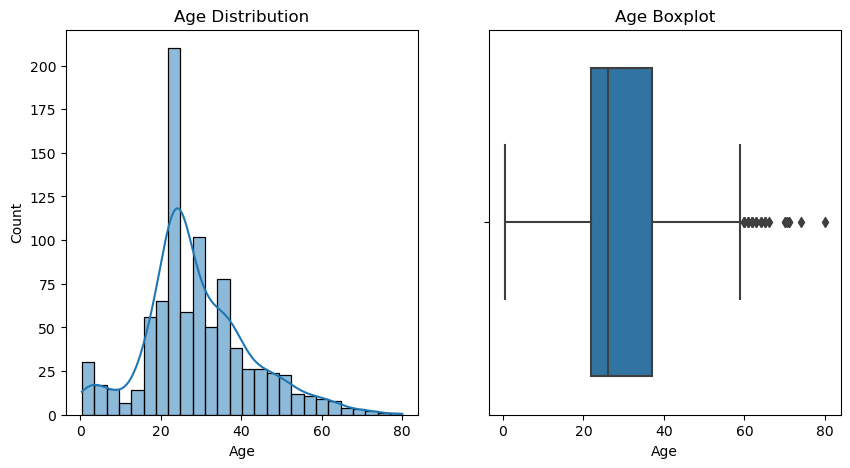

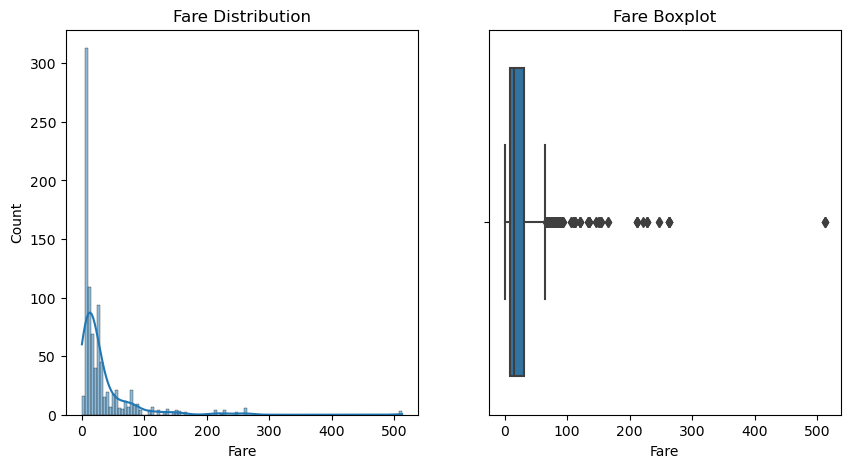

In [40]:
continuous = [column for column in train.columns if train[column].dtype=='float64']
continuous

# 'SibSp' and 'Parch' representing the count of family members' are int64', could be treated as continuous or ordinal. 
# I am going to be treating them as ordinals. 

for i, column in enumerate(continuous):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(train[column], kde=True)
    plt.title(column + ' Distribution')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[column])
    plt.title(column + ' Boxplot')

    plt.show()


### 4.1. log transform

In [41]:
# Measure skewness for 'Age' and 'Fare'
age_skewness = skew(train['Age'])  
fare_skewness = skew(train['Fare'])

print(f'Skewness of Age: {age_skewness}')
print(f'Skewness of Fare: {fare_skewness}')
# The skewness values you've provided show that the Fare column has a high positive skewness (4.79),
# indicating a long right tail. The Age column has a skewness of 0.54, which is closer to normal distribution but still slightly right-skewed.

Skewness of Age: 0.5473323082370296
Skewness of Fare: 4.7792532923723545


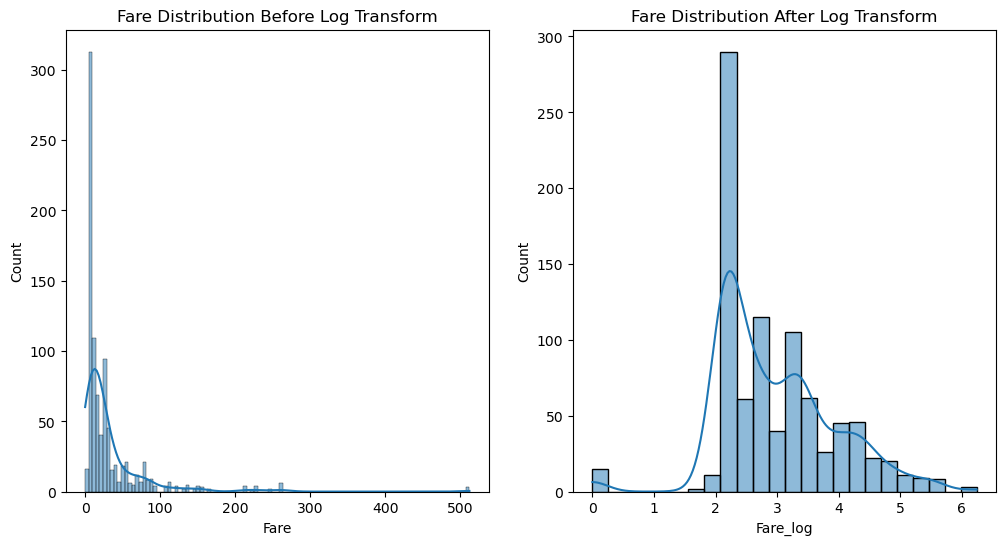

In [42]:
# Apply log transformation to Fare
train['Fare_log'] = np.log1p(train['Fare'])

# 'SibSp' and 'Parch' representing the count of family members' are int64', could be treated as continuous or ordinal. 
# I am going to be treating them as ordinals. 

log_transformed = ['Fare']

for i, column in enumerate(log_transformed):
    # Visualize the distribution before and after log transformation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(train[column], ax=ax1, kde=True)
    ax1.set_title(column + ' Distribution Before Log Transform')

    sns.histplot(train[column + '_log'], ax=ax2, kde=True)
    ax2.set_title(column + ' Distribution After Log Transform')

    plt.show()

In [43]:
# Recalculate skewness for transformed 'Fare'
fare_skewness_log = train['Fare_log'].skew()
print(fare_skewness_log)

# Drop untransformed column
train.drop(['Fare'], axis=1, inplace=True)

0.3949280095189306


## Visualizing Ordinal variables

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   FamilySize      891 non-null    int64  
 6   Sex_male        891 non-null    bool   
 7   Embarked_Q      891 non-null    bool   
 8   Embarked_S      891 non-null    bool   
 9   IsAlone_1       891 non-null    bool   
 10  AgeBin_encoded  891 non-null    int8   
 11  Title_encoded   891 non-null    int64  
 12  Deck_encoded    891 non-null    int64  
 13  Fare_log        891 non-null    float64
dtypes: bool(4), float64(2), int64(7), int8(1)
memory usage: 67.1 KB


In [45]:
ordinal_columns = ['Pclass', 'SibSp', 'Parch','FamilySize']

<Figure size 640x480 with 0 Axes>

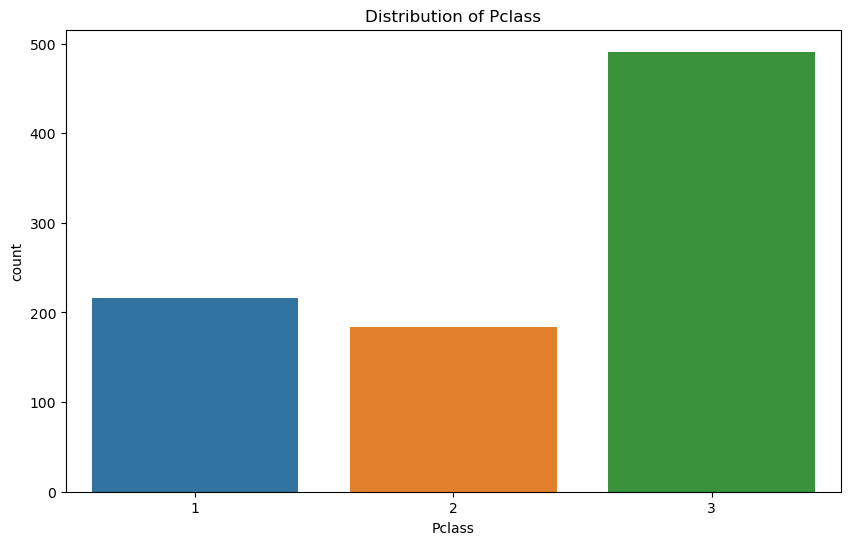

<Figure size 640x480 with 0 Axes>

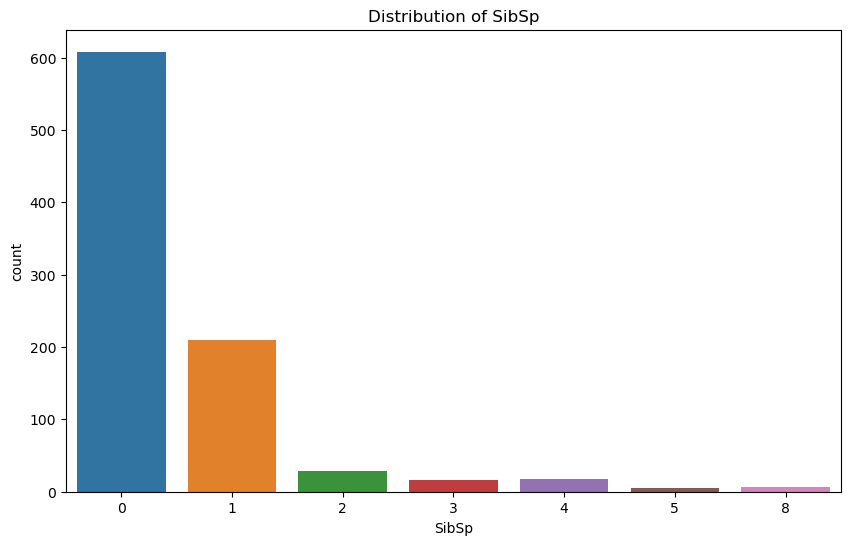

<Figure size 640x480 with 0 Axes>

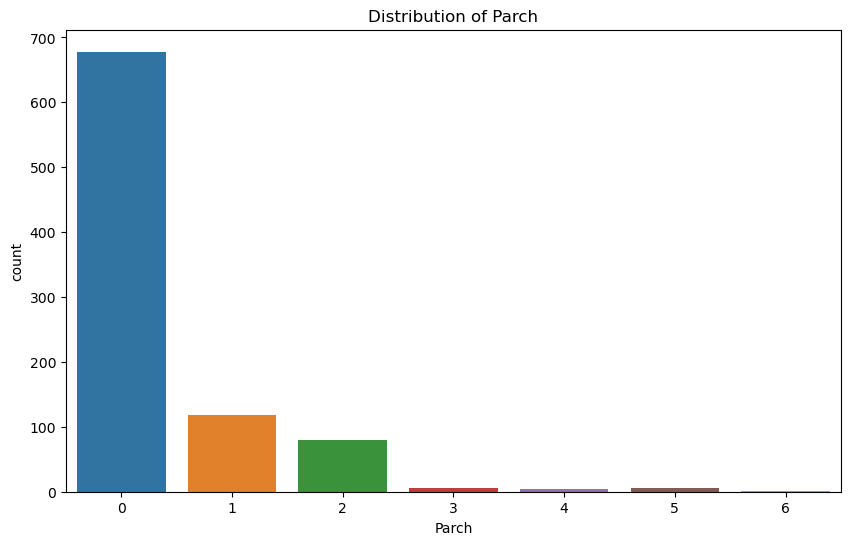

<Figure size 640x480 with 0 Axes>

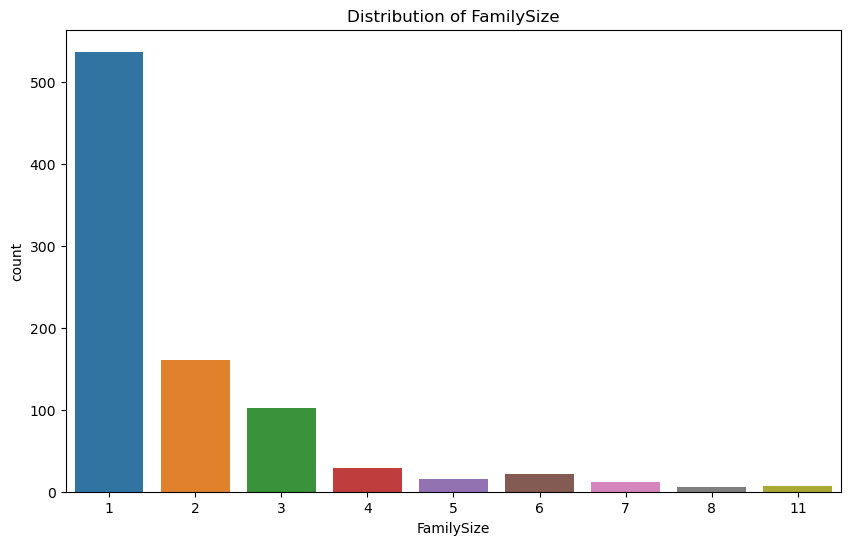

In [46]:
# Loop over the ordinal columns to plot their distributions
for i, column in enumerate(ordinal_columns):
    plt.figure(i)
    f, ax = plt.subplots(figsize=(10, 6))
    
    # Create a countplot to visualize distribution of ordinal variables
    sns.countplot(x=column, data=train)
    
    # Add title
    plt.title(f'Distribution of {column}')
    
    # Show the plot
    plt.show()

## Correlation Analysis

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   FamilySize      891 non-null    int64  
 6   Sex_male        891 non-null    bool   
 7   Embarked_Q      891 non-null    bool   
 8   Embarked_S      891 non-null    bool   
 9   IsAlone_1       891 non-null    bool   
 10  AgeBin_encoded  891 non-null    int8   
 11  Title_encoded   891 non-null    int64  
 12  Deck_encoded    891 non-null    int64  
 13  Fare_log        891 non-null    float64
dtypes: bool(4), float64(2), int64(7), int8(1)
memory usage: 67.1 KB


In [48]:
numerical = [column for column in train.columns if (train[column].dtype in ['float64','int64'])]
corr_columns = numerical + ['Sex_male','IsAlone_1'] # Adding Sex_male as binary categorical variables
corr_columns

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'FamilySize',
 'Title_encoded',
 'Deck_encoded',
 'Fare_log',
 'Sex_male',
 'IsAlone_1']

<Figure size 640x480 with 0 Axes>

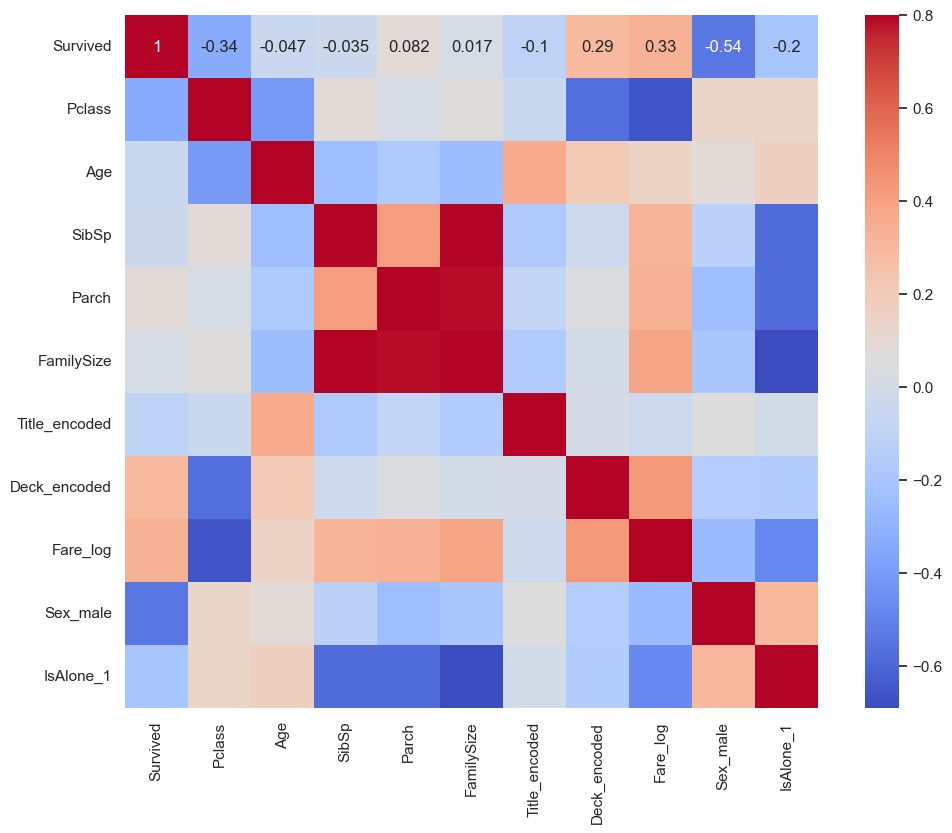

<Figure size 640x480 with 0 Axes>

In [49]:
corr_matrix = train[corr_columns].corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True, cmap='coolwarm',annot=True)
plt.figure()

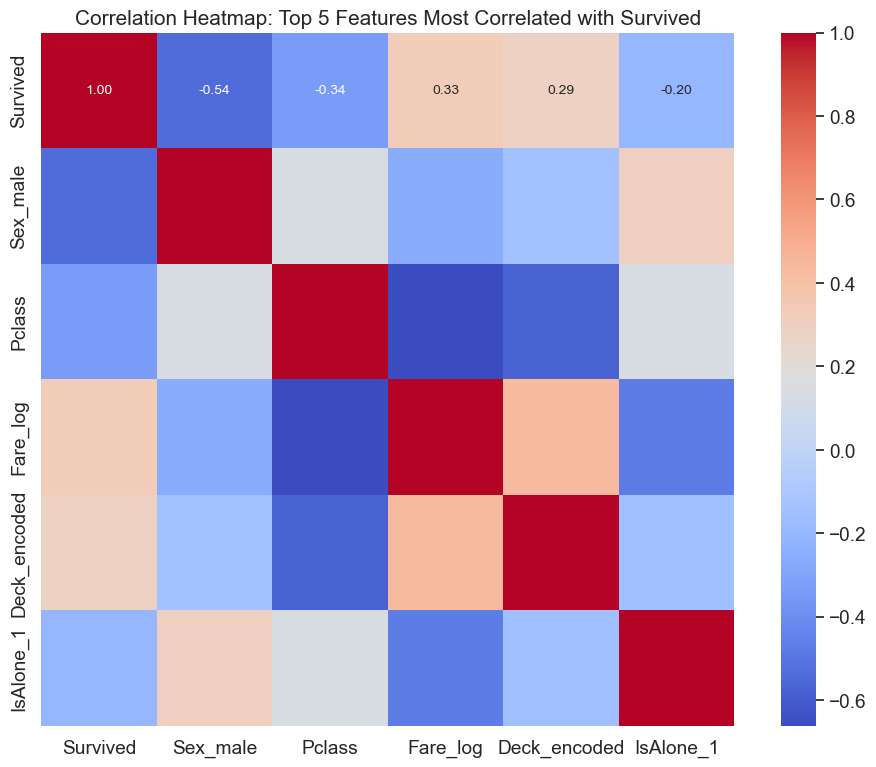

In [50]:
# Plotting top 3 variables correlated with 'Survived'
# Set parameters
k = 5
column_estimate = 'Survived'

# Get absolute correlation matrix
corr_matrix = train[corr_columns].corr()

# Get the top k features with the largest absolute correlation to 'Survived'
cols = corr_matrix[column_estimate].abs().nlargest(k+1).index

# Create the correlation matrix of the selected columns
cm = np.corrcoef(train[cols].astype(float).values.T)

# Plot heatmap
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, cmap='coolwarm', annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title(f'Correlation Heatmap: Top {k} Features Most Correlated with {column_estimate}')
plt.show()

# Train test split

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   FamilySize      891 non-null    int64  
 6   Sex_male        891 non-null    bool   
 7   Embarked_Q      891 non-null    bool   
 8   Embarked_S      891 non-null    bool   
 9   IsAlone_1       891 non-null    bool   
 10  AgeBin_encoded  891 non-null    int8   
 11  Title_encoded   891 non-null    int64  
 12  Deck_encoded    891 non-null    int64  
 13  Fare_log        891 non-null    float64
dtypes: bool(4), float64(2), int64(7), int8(1)
memory usage: 67.1 KB


In [52]:
def titanic_train_test_split(df, test_size=0.3, random_state=123):
    X = train.drop('Survived', axis=1)
    y = train['Survived']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return (X, y, X_train, X_test, y_train, y_test)

In [53]:
# Split the data into training and test sets
X, y, X_train, X_test, y_train, y_test = titanic_train_test_split(train, test_size=0.3, random_state=123)

# Scale continuosus variables

In [54]:
# Scaling continous variables

columns_to_scale = [column for column in train.columns if train[column].dtype=='float64']
print(columns_to_scale)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Save the scaler to a file to be used on test data
joblib.dump(scaler, '../models/scaler.pkl')

# Later, you can load the scaler to use it on the test data
X_test[columns_to_scale] =scaler.transform(X_test[columns_to_scale])

['Age', 'Fare_log']


# Feature selection with Random Forest

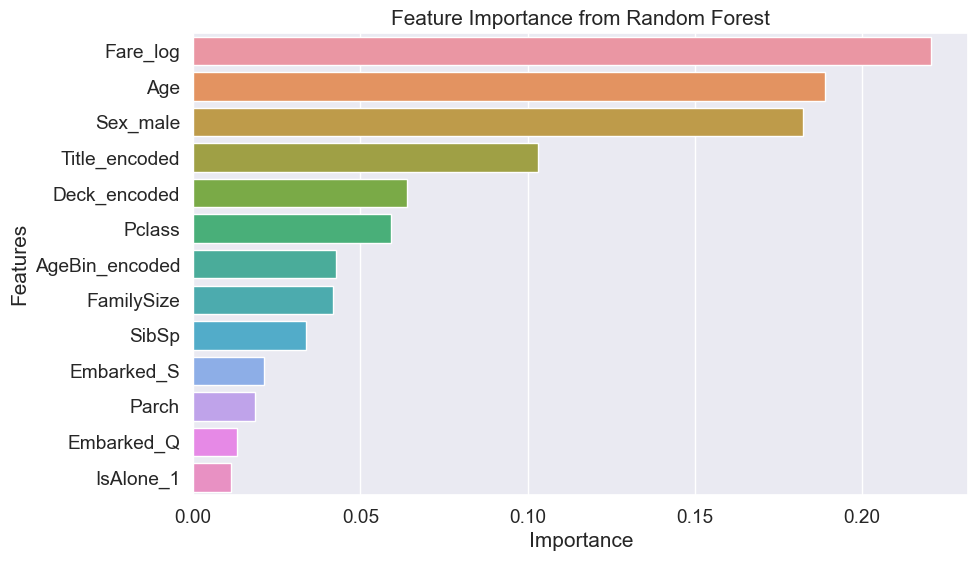

In [55]:
# Initialize a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feat_importances_df = pd.DataFrame({
    'Features': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top N important features (for example, top 5)
#top_n = 5
#top_features = feat_importances_df['Features'][:top_n]
#print("Top {} features: \n".format(top_n), top_features)

# Reduce your dataset to only include the top N important features
#X_train_selected = X_train[top_features]
#X_test_selected = X_test[top_features]

# Plot the feature importance with labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=feat_importances_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



In [56]:
# Base on these results, and correlation plots, I am going to drop some columns
train.drop(['IsAlone_1','Embarked_Q','Parch', 'Embarked_S','AgeBin_encoded','SibSp'], axis=1, inplace=True)

In [57]:
# Final features
train.columns

Index(['Survived', 'Pclass', 'Age', 'FamilySize', 'Sex_male', 'Title_encoded',
       'Deck_encoded', 'Fare_log'],
      dtype='object')

# Training 

In [58]:
# Repeat train test split and scale because we dropped a few variables after feature selection
# Split the data into training and test sets
X, y, X_train, X_test, y_train, y_test = titanic_train_test_split(train, test_size=0.3, random_state=123)

# Scaling continous variables

columns_to_scale = [column for column in train.columns if train[column].dtype=='float64']
print(columns_to_scale)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Save the scaler to a file to be used on test data
joblib.dump(scaler, 'titanin_scaler.pkl')

# Later, you can load the scaler to use it on the test data
#scaler_loaded = joblib.load('scaler.pkl')
X_test[columns_to_scale] =scaler.transform(X_test[columns_to_scale])

['Age', 'Fare_log']


In [59]:
def generate_optimized_model(model, X_train, y_train, X, y, param_grid, scoring='accuracy'):    
    # Step 1: Hyperparameter tuning on the training data
    estimator = model()
    
    param_search = RandomizedSearchCV(
        estimator=estimator, 
        param_distributions=param_grid, 
        n_iter=50, 
        scoring=scoring, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        random_state=123
    )
    
    param_search = param_search.fit(X_train.values, y_train.values)
    
    print('Finished doing grid search for ' + model.__name__)
    print('Finished generating train model fit on X_train and y_train')

    print('Mean cross-validation score (accuracy) of best estimator:')
    print(param_search.best_score_)

    # Best hyperparameters from tuning
    best_params = {**param_search.best_params_}
    print('Best params:')
    print(best_params)

    # Model fitted on the train set
    best_estimator_train = param_search.best_estimator_

    # Step 2: Fit the model on the full dataset with the best params
    final_estimator_full = model(**best_params)
    final_estimator_full.fit(X.values, y.values)
    
    print('Finished generating final model fit on the full dataset')

    return best_estimator_train, final_estimator_full
                   

In [60]:
def save_or_load_optimized_model(model_class, model_path, X_train, y_train, \
                                X, y, param_grid, regenerate_model):
    model_name= model_class.__name__
    optimized_model_train_filename = model_path + '_'+ model_name+'_train.pkl'
    optimized_model_all_filename = model_path + '_'+ model_name+'_full.pkl'
    
    if regenerate_model:
        best_estimator_train, final_estimator_full = generate_optimized_model(model_class, X_train, y_train, X, y, param_grid, scoring='accuracy')
        
        with open(optimized_model_train_filename, 'wb') as file:
            pickle.dump(best_estimator_train, file)

        with open(optimized_model_all_filename, 'wb') as file:
            pickle.dump(final_estimator_full, file)
        
        print('finished saving final models for ' + model_name + ' Survived')

    else:
        with open(optimized_model_train_filename, 'rb') as file:
            optimized_model_train = pickle.load(file)

        with open(optimized_model_all_filename, 'rb') as file:
            optimized_model_full = pickle.load(file)
        
        print('finished loading models for ' + model_name + ' Survived')

    return (best_estimator_train, final_estimator_full)

# Model Selection

In [61]:
def cv_score(model, X_train, y_train, scoring="accuracy", n_folds = 5):
    kf = KFold(shuffle=True, random_state = 10)
    cvs = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
    return cvs

In [62]:
def mean_confidence_interval(scores, confidence=0.95):
    a = 1.0 *np.array(scores)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t.ppf((1+ confidence)/2., n-1)
    print('Accuracy: %0.3f (+/- %0.3f)' % (m,h))
    return "%0.3f (+/- %0.3f)" % (m,h)

In [63]:
def get_train_error(optimized_model, X_train, y_train):
    model_cv_score_accuracy = cv_score(optimized_model, X_train, y_train)
    cv_accuracy = mean_confidence_interval(model_cv_score_accuracy)
    print('finished calculating cv score accuracy')

    model_cv_score_precision = cv_score(optimized_model, X_train, y_train, scoring='precision')
    cv_precision = mean_confidence_interval(model_cv_score_precision)
    print('finished calculating cv score precision')

    model_cv_score_recall = cv_score(optimized_model, X_train, y_train, scoring='recall')
    cv_recall = mean_confidence_interval(model_cv_score_recall)
    print('finished calculating cv score recall')
    
    return (cv_accuracy, cv_precision, cv_recall)

In [64]:
def get_test_error(optimized_model, X_test, y_test):
    pred = optimized_model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')  
    print('finished calculating test error')
    return (accuracy, precision, recall, f1)

In [65]:
def generate_feature_report_linear(model_name, optimized_model, X,linear):
    X_shape = X.columns.shape[0]
    if linear:
        coef = pd.DataFrame(optimized_model.coef_.reshape(X_shape, 1), index= X.columns, 
                       columns = [model_name + '_coef']).sort_values(model_name + '_coef', ascending=False)
        coef = coef.iloc[coef[model_name + '_coef'].abs().argsort()[::-1]]
        print('Grid:' + str(len(optimized_model.coef_)) + ' coeffs')
        print(coef)
    else:
        feature_importances = optimized_model.feature_importances_

        feat_importances_df = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print('Feature importance:' + str(len(optimized_model.feature_importances_)) + ' features')
        print(feat_importances_df)

In [66]:
target_variable_name = 'Survived'

In [67]:
def run_titanic_pipeline(model, target_variable_name, param_grid, model_path, linear,\
                        regenerate_model):
    model_name = model.__name__
    optimized_model_train, optimized_model_all = save_or_load_optimized_model(model, model_path, X_train, y_train, \
                                X, y, param_grid, regenerate_model)
    print('generated optimized model')
    cv_accuracy, cv_precision, cv_recall = get_train_error(optimized_model_train, X_train, y_train)
    accuracy, precision, recall, f1 = get_test_error(optimized_model_train, X_test, y_test)

    print('Generated performance metrics for test')
    print('Finished calculating train and test error for ' + model_name)
    print('X_train: ' + str(len(X.columns)) + ': columns')

    print(optimized_model_train)
    print('train cv_score_accuracy:{}'.format(cv_accuracy))
    print('train cv_score_precision:{}'.format(cv_precision))
    print('train cv_score_recall:{}'.format(cv_recall))
    print('test accuracy:{}'.format(accuracy))
    print('test precision:{}'.format(precision))
    print('test recall:{}'.format(recall))

    performance_metrics_summary = pd.DataFrame(
        [[model_name, target_variable_name, cv_accuracy, cv_precision, cv_recall, accuracy, precision, recall]],\
        columns = ['model', 'target', 'train cv_accuracy','train cv_precision','train cv_recall','test accuracy',\
                   'test precision', 'test recall'])

    generate_feature_report_linear(model_name, optimized_model_train, X, linear)
    return performance_metrics_summary
    

In [68]:
def run_pipeline_for_all_models(df, target_variable_name, chosen_models, models_path, regenerate_model=True):

    reports = []

    for (model_class, grid_search_param_sets, linear) in chosen_models:

        model_report = run_titanic_pipeline(model_class, target_variable_name, grid_search_param_sets, models_path, linear,\
                        regenerate_model)
        reports.append(model_report)

    return reports

In [69]:
rf_random_grid = {
    'n_estimators': [50, 100, 200, 500],            # Number of trees
    'max_depth': [None, 10, 20, 30, 40],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                      # Method of sampling for trees
}

lr_random_grid = {
    'penalty':['l2'], 
    'solver':['lbfgs'],
    'C': np.logspace(-3, 3, 10),  # Regularization strength
    'class_weight': [None, 'balanced'],  # Use balanced class weights
    'max_iter': [100, 200, 500]  # Maximum number of iterations to ensure convergence
}

xgb_param_grid = {
    'use_label_encoder':['False','True'],
    'n_estimators': [50,100],
    'learning_rate': [0.2, 0.3],
}

In [70]:
chosen_models = [(LogisticRegression, lr_random_grid, True), (RandomForestClassifier, rf_random_grid, False),\
                (xgb.XGBClassifier, xgb_param_grid, False)]

reports_for_all_models = run_pipeline_for_all_models(train, 'Survived', chosen_models, '../models/titanic', regenerate_model=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Finished doing grid search for LogisticRegression
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.8090193548387097
Best params:
{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'class_weight': None, 'C': 2.154434690031882}
Finished generating final model fit on the full dataset
finished saving final models for LogisticRegression Survived
generated optimized model
Accuracy: 0.793 (+/- 0.021)
finished calculating cv score accuracy
Accuracy: 0.756 (+/- 0.127)
finished calculating cv score precision
Accuracy: 0.708 (+/- 0.060)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for LogisticRegression
X_train: 7: columns
LogisticRegression(C=2.154434690031882, max_iter=200)
train cv_score_accuracy:0.793 (+/- 0.021)
train cv_score_precision:0.756 (+/- 0.127)
t

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:32:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:32:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:32:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning

Finished doing grid search for XGBClassifier
Finished generating train model fit on X_train and y_train
Mean cross-validation score (accuracy) of best estimator:
0.8169548387096774
Best params:
{'use_label_encoder': 'False', 'n_estimators': 50, 'learning_rate': 0.2}
Finished generating final model fit on the full dataset
finished saving final models for XGBClassifier Survived
generated optimized model
Accuracy: 0.798 (+/- 0.031)
finished calculating cv score accuracy
Accuracy: 0.762 (+/- 0.074)
finished calculating cv score precision
Accuracy: 0.709 (+/- 0.059)
finished calculating cv score recall
finished calculating test error
Generated performance metrics for test
Finished calculating train and test error for XGBClassifier
X_train: 7: columns
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval

In [71]:
reports_for_all_models

[                model    target  train cv_accuracy train cv_precision  \
 0  LogisticRegression  Survived  0.793 (+/- 0.021)  0.756 (+/- 0.127)   
 
      train cv_recall  test accuracy  test precision  test recall  
 0  0.708 (+/- 0.060)       0.798507        0.797026     0.798507  ,
                     model    target  train cv_accuracy train cv_precision  \
 0  RandomForestClassifier  Survived  0.825 (+/- 0.035)  0.799 (+/- 0.068)   
 
      train cv_recall  test accuracy  test precision  test recall  
 0  0.729 (+/- 0.071)       0.850746        0.849464     0.850746  ,
            model    target  train cv_accuracy train cv_precision  \
 0  XGBClassifier  Survived  0.798 (+/- 0.031)  0.762 (+/- 0.074)   
 
      train cv_recall  test accuracy  test precision  test recall  
 0  0.709 (+/- 0.059)       0.850746        0.849568     0.850746  ]

In [72]:
train.columns

Index(['Survived', 'Pclass', 'Age', 'FamilySize', 'Sex_male', 'Title_encoded',
       'Deck_encoded', 'Fare_log'],
      dtype='object')

# Chosen model Random Forest 

### I chose Random Forest becasued it has the highest perfomance in the train portion of the train set

In [75]:
with open('../models/titanic_RandomForestClassifier_train.pkl', 'rb') as file:
    optimized_model_train = pickle.load(file)

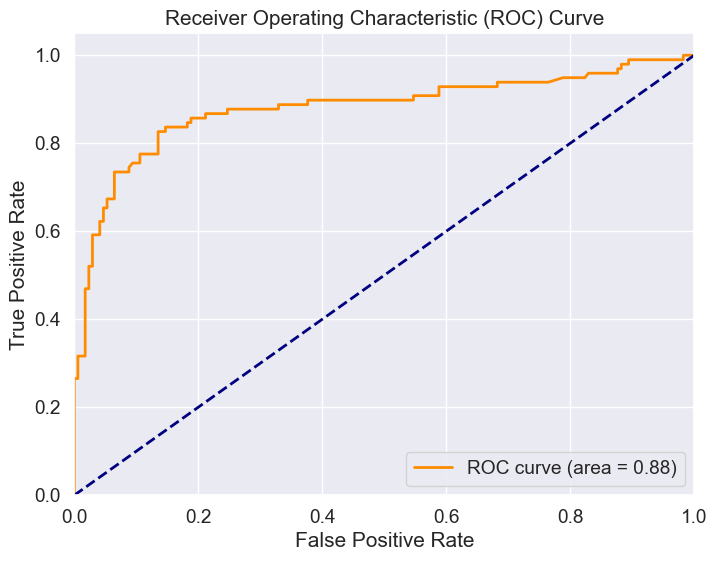

In [76]:
def plot_roc_auc(model, X_test, y_test):
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage with the trained model
plot_roc_auc(optimized_model_train, X_test, y_test)

In [77]:
def find_best_cutoff(model, X_test, y_test):
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate Youden's J statistic for each threshold
    youdens_j = tpr - fpr

    # Find the index of the maximum Youden's J statistic
    best_index = np.argmax(youdens_j)

    # Get the best threshold
    best_threshold = thresholds[best_index]

    print(f"Best cutoff threshold: {best_threshold}")
    return best_threshold

best_cutoff = find_best_cutoff(optimized_model_train, X_test, y_test)

Best cutoff threshold: 0.4398288711549581


In [78]:
def print_classification_report(model, X_test, y_test, threshold=0.5):
    """
    Prints the classification report for the model using predict_proba with a specified threshold.
    
    Parameters:
    model (classifier): Trained classification model.
    X_test (DataFrame): Features for testing.
    y_test (Series): True labels for testing.
    threshold (float): The probability threshold for classifying a prediction as positive.
    
    Returns:
    None
    """
    # Generate prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Convert probabilities into binary predictions based on the specified threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Generate the classification report
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)


In [79]:
print_classification_report(optimized_model_train, X_test, y_test, threshold = best_cutoff )

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       170
           1       0.78      0.83      0.80        98

    accuracy                           0.85       268
   macro avg       0.84      0.85      0.84       268
weighted avg       0.85      0.85      0.85       268



In [80]:
def get_test_error_custom_threshols(optimized_model, X_test, y_test, threshold=0.5):
    # Get the predicted probabilities
    y_pred_prob = optimized_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Apply the custom threshold
    y_pred_custom = (y_pred_prob >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_custom)
    precision = precision_score(y_test, y_pred_custom, average='weighted')
    recall = recall_score(y_test, y_pred_custom, average='weighted')
    f1 = f1_score(y_test, y_pred_custom, average='weighted')  
    print('finished calculating test error with custom threshold')
    
    return (accuracy, precision, recall, f1)

In [81]:
accuracy, precision, recall, f1 = get_test_error_custom_threshols(optimized_model_train, X_test, y_test, best_cutoff)
print('Test accuracy: {:.3f}'.format(accuracy))
print('Test precision: {:.3f}'.format(precision))
print('Test recall: {:.3f}'.format(recall))
print('Test F1-score: {:.3f}'.format(f1))

finished calculating test error with custom threshold
Test accuracy: 0.851
Test precision: 0.853
Test recall: 0.851
Test F1-score: 0.852


In [83]:
# The model fit on the full train ('titanic_train.csv') will be used for inference
with open('../models/titanic_RandomForestClassifier_full.pkl', 'rb') as file:
    optimized_model_full = pickle.load(file)